In [ ]:
pip install strawberryfields

In [2]:
import strawberryfields as sf
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [18]:
from strawberryfields import ops
from typing import NamedTuple

In [6]:
class Dataset(NamedTuple):
    trainX: np.array
    trainY: np.array
    testX: np.array
    testY: np.array

In [14]:
def make_dataset(classes_scales: tuple, intersect_rate: float) -> Dataset:
    np.random.seed(0)
    n=2

    X0 = np.array([[-1, -1]]) + intersect_rate*np.random.randn(classes_scales[0], n)
    X1 = np.array([[1, 1]]) + intersect_rate*np.random.randn(classes_scales[1], n)

    #конкатенируем все в одну матрицу
    #при этом по 20 точек оставим на тест/валидацию
    sep0 = round(classes_scales[0]*0.1)
    sep1 = round(classes_scales[1]*0.1)
    X = np.vstack((X0[sep0:], X1[sep1:]))
    ValX = np.vstack((X0[:sep0], X1[:sep1]))

    #конкатенируем все в один столбец с соответствующими значениями для класса 0 или 1
    y = np.hstack([[0]*(classes_scales[0]-sep0), [1]*(classes_scales[1]-sep1)])
    ValY = np.hstack([[0]*sep0, [1]*sep1])

    return Dataset(trainX=X, trainY=y, testX=ValX, testY=ValY)

In [16]:
def visualize_dataset(dataset: Dataset):
    colors = ['blue', 'red', 'yellow', 'green', 'black', 'pink', 'orange', 'purple']

    for k in np.unique(dataset.trainY):
        plt.plot(dataset.trainX[dataset.trainY == k, 0], dataset.trainX[dataset.trainY == k, 1], 'o', label='train class {}'.format(k), color=colors[k])

    for k in np.unique(dataset.testY):
        plt.plot(dataset.testX[dataset.testY == k, 0], dataset.testX[dataset.testY == k, 1], 'o', label='test class {}'.format(k), color=colors[k+4])

    plt.legend(fontsize=7, ncol=1, facecolor='oldlace', edgecolor='r')
    plt.show

In [63]:
def circuit(X):
    modes = 2
    layers = 8
    cutoff_dim = 6


    # defining desired state (single photon state)
    target_state = np.zeros(cutoff_dim)
    target_state[1] = 1
    target_state = tf.constant(target_state, dtype=tf.complex64)

    # initialize engine and program
    eng = sf.Engine(backend="tf", backend_options={"cutoff_dim": cutoff_dim})
    qnn = sf.Program(modes)

    # initialize QNN weights
    # weights = init_weights(modes, layers)
    # num_params = np.prod(weights.shape)

    # Create array of Strawberry Fields symbolic gate arguments, matching
    # the size of the weights Variable.
    # sf_params = np.arange(num_params).reshape(weights.shape).astype(np.str)
    # sf_params = np.array([qnn.params(*i) for i in sf_params])

    sq = qnn.params('sq')
    x0, x1 = qnn.params("x0"), qnn.params("x1")

    params = np.array([qnn.params(f'phi+{i}') for i in range(9)])
    mapping = {p.name: tf.Variable(0.5) for p in params.flatten()}
    mapping.update({'sq': tf.constant(1.5), 'x0': tf.Variable(0.5), 'x1': tf.Variable(0.2)})

    with qnn.context as q:
        # ops.Sgate(sq, X[:, 0]) | q[0]
        # ops.Sgate(sq, X[:, 1]) | q[1]
        ops.Sgate(sq, x0) | q[0]
        ops.Sgate(sq, x1) | q[1]
        ops.BSgate(params[0], params[7]) | (q[0], q[1])
        ops.Dgate(params[1]) | q[0]
        ops.Dgate(params[2]) | q[1]
        ops.Pgate(params[3]) | q[0]
        ops.Pgate(params[4]) | q[1]
        ops.Kgate(params[5]) | q[0]
        ops.Kgate(params[6]) | q[1]

    result = eng.run(qnn, args=mapping)
    print(result.state)

In [64]:
circuit(np.array([[0.5, 0.1], [0.5, 0.5]]))

<FockStateTF: num_modes=2, cutoff=6, pure=True, batched=False, hbar=2, dtype=<dtype: 'complex64'>>


In [ ]:
class Model:
    def __init__(self) -> None:
        self.params, self.lr, self.steps = None, None, None

    def fit(self, lr: float, steps: int, trainX: np.array, trainY: np.array, decay=None) -> None:
        pass


##Training and Scoring

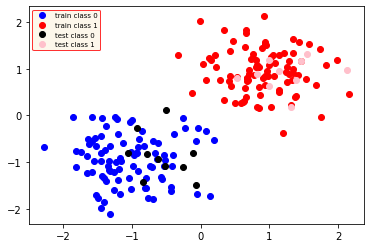

In [17]:
dataset = make_dataset((100, 100), 0.5)
visualize_dataset(dataset)